In [1]:
"""
Tutorial on testing significance and working with CESM simulation data

Cameron Cummins 6/16/22

In this tutorial, we will measure the stasticial difference between two independent simulations: average annual min. temperature between ALL and XAER.
We use a Welch's t-test to determine if the ensemble means are significantly different at a given location over a specified period of time.
"""

import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from os import listdir

In [2]:
""" This path file is talked about in the 'basics' tutorial. It contains the paths to thedata we want to use"""
from project_paths import get_annual_avg_trefhtmn as tmin_paths

In [3]:
# Load datasets for XAER and ALL
all_paths, xaer_paths = tmin_paths()

# Maybe we want to select a particluar time period, say 1960-1989. We use the slice() function to include multiple years within a range
all_ds = xarray.open_mfdataset(all_paths, combine='nested', concat_dim="member")["TREFHTMN"].sel(year=slice(1960, 1989))
xaer_ds = xarray.open_mfdataset(xaer_paths, combine='nested', concat_dim="member")["TREFHTMN"].sel(year=slice(1960, 1989))
all_ds

<xarray.DataArray 'TREFHTMN' (member: 5, year: 30, lat: 192, lon: 288)>
dask.array<getitem, shape=(5, 30, 192, 288), dtype=float32, chunksize=(1, 30, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 1960 1961 1962 1963 1964 ... 1985 1986 1987 1988 1989
Dimensions without coordinates: member

In [4]:
# Unfortunately, xarray is a bit too slow for running the t-test point by point, so we will need to
# do some data manipulation to achieve this in a reasonable amount of time. If I find a better way
# to do it, then I'll let you know. But for now, we need to convert to numpy, do the test, and then
# convert back to xarray.

from scipy.stats import ttest_ind # this is the function for computing the Welch's t-test

# Here we convert from xarray to numpy, losing most attributes and features but increasing performance
all_array = all_ds.values
xaer_array = xaer_ds.values

def welch_t_test(all_pt, xaer_pt, lat, lon):
    # Confirmed that Sarah's modified t test is just a welches t test using my own code
    t_val, p_val = ttest_ind(all_pt, xaer_pt, equal_var=False)
    return ((lat, lon), p_val)

results = []
# We then iterate through each point in the datasets
for lati, lat in enumerate(all_ds.lat.values):
    for loni, lon in enumerate(all_ds.lon.values):
        # This is when things get a bit tricky. Basically, since the numpy arrays don't have fancy labels
        # they get treated as true arrays. Meaning we need to access them like arrays are accessed in C or
        # other lower-level programming languages: we use indices, not values.
        # The first coordinate in the array accesses members, and here we are specifying to access indices
        # 0 through the size of the array, so basically all members.
        # The second coordinate accesses time, and we do the same: from 0 to the end.
        # The thrid and fourth access lat and lon respectively, so we only one for each that specify the point
        all_pt = all_array[0:all_ds["member"].size, 0:all_ds["year"].size, lati, loni].flatten()
        # Lastly, we flatten the array, which basically takes all elements and puts them into a single dimension
        # The result is a 1-d array with size equal to the number of members times the number of years
        xaer_pt = xaer_array[0:xaer_ds["member"].size, 0:xaer_ds["year"].size, lati, loni].flatten()
        
        # With the two 1-d arrays, we can preform a t-test and obtain a t-value and p-value
        t_value, p_value = ttest_ind(all_pt, xaer_pt, equal_var=False) # We specify that the variances are not equal
        # We then store the p_value in an array along with the coordinates for the point in a tuple
        results.append(((lat, lon), p_value))

# We can preform a quick check to make sure everything went correctly. Since we ran a t-test on each point
# then we should have a list of results that is equal in length to the number of points we have.
if len(results) != all_ds.lat.size*all_ds.lon.size:
    raise RuntimeError(f'The results do not match the original dataset size!')

# To carry over our attributes, we make a copy of the ALL dataset, set everything to zero, and rename the variable
sig_results = (all_ds.mean(dim="member").mean(dim="year").load() * 0).rename("p-value")
# We then iterate through each point in the results
for (lat, lon), p_value in results: # Note how we unpack the tuple in the for loop header
    # We then locate the point in the ALL copy we made and change the value from 0 to whatever the p-value is
    sig_results.loc[dict(lat=lat, lon=lon)] = p_value

# Now we have a dataset of the same lat-lon dimensions as ALL and XAER with p-values for each point
sig_results

<xarray.DataArray 'p-value' (lat: 192, lon: 288)>
array([[1.1881112e-02, 1.1505163e-02, 1.1806033e-02, ..., 1.1917154e-02,
        1.1788453e-02, 1.2037911e-02],
       [4.6373907e-02, 1.4159938e-02, 3.9453488e-02, ..., 3.0355819e-02,
        1.6023992e-02, 2.7892860e-02],
       [3.7934948e-02, 6.9692120e-02, 3.3327118e-02, ..., 3.5961315e-02,
        4.7816809e-02, 3.6247104e-02],
       ...,
       [2.2661926e-18, 2.6704753e-18, 3.1082161e-18, ..., 1.5382722e-18,
        1.7605896e-18, 1.9780701e-18],
       [1.6138049e-19, 1.7244036e-19, 1.8448651e-19, ..., 1.2791861e-19,
        1.3917378e-19, 1.5016549e-19],
       [3.0406326e-20, 3.0630337e-20, 3.0620646e-20, ..., 3.0016769e-20,
        3.0222356e-20, 3.0355383e-20]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

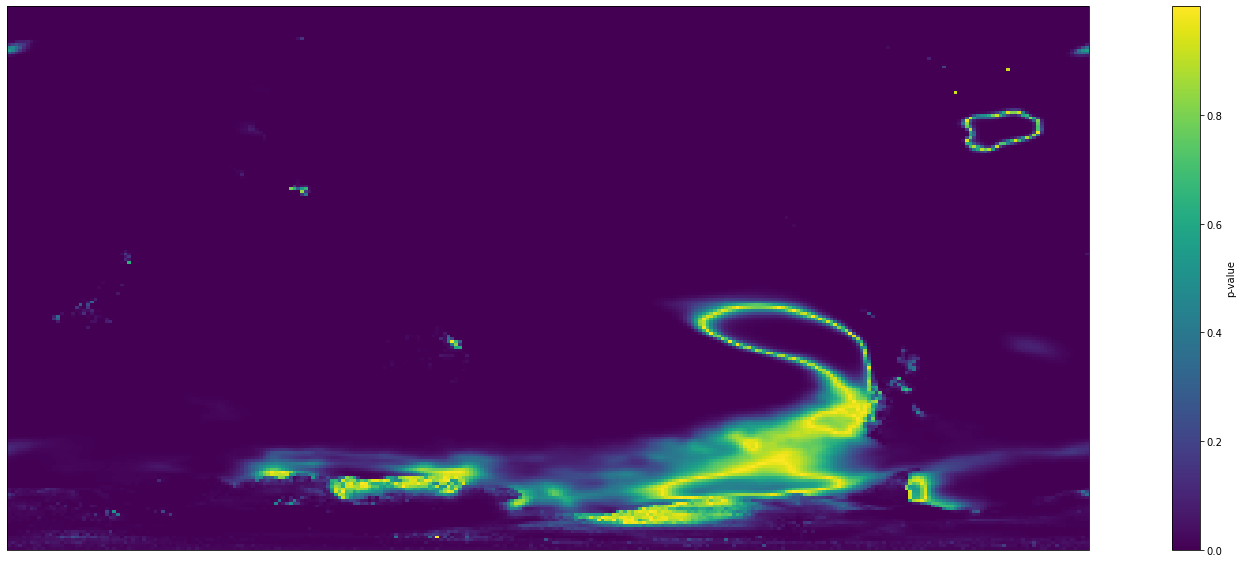

In [5]:
f, ax = plt.subplots(1, 1, figsize=(30, 10), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})
sig_results.plot(ax=ax)

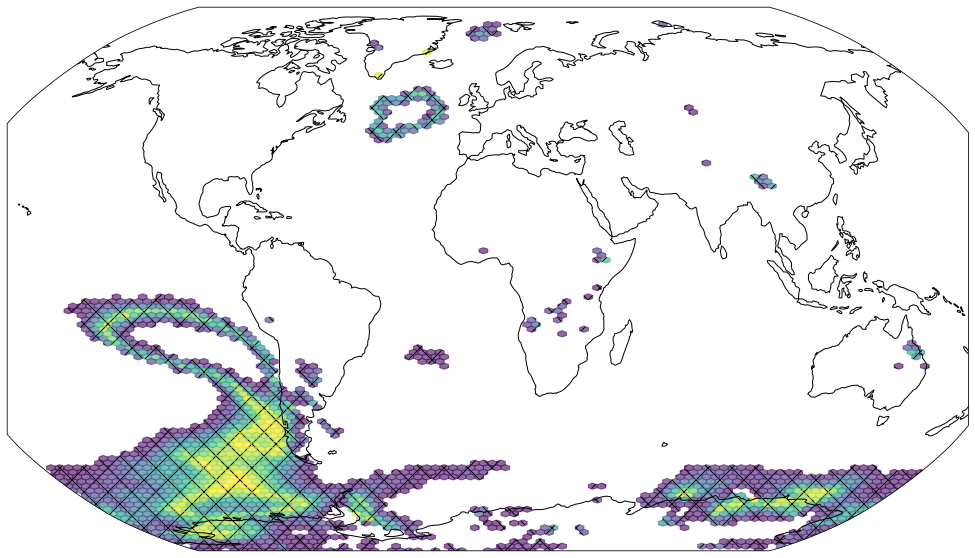

In [11]:
import numpy as np
# For overlay on top of the ALL results, we will need to convert our results into a boolean array, indicating T/F for whether or not
# the p-value exceeds our significance threshold of 5%
sig_mask = sig_results.where(sig_results >= 0.05) # All points that exceed 5% will be marked true, indicating they are not significantly different

# For an overlay, we want to use hexbin()
# hexbin() needs a finer set of axis for plotting, so we create a meshgrid of the same dimensions
X, Y = np.meshgrid(sig_results.lon, sig_results.lat) # This will basically interpolate values in between each lat/lon value to make a finer grid
f, ax = plt.subplots(1, 1, figsize=(30, 10), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})

ax.hexbin(X.reshape(-1), Y.reshape(-1), sig_mask.data.reshape(-1), hatch='x', alpha=0.6, transform=ccrs.PlateCarree())
# Note that transform is needed in order to use other projections like the Robinson projection here
# We can also control how to view the p-value (if we want to see it)
ax.coastlines() # Adds contour of coastlines

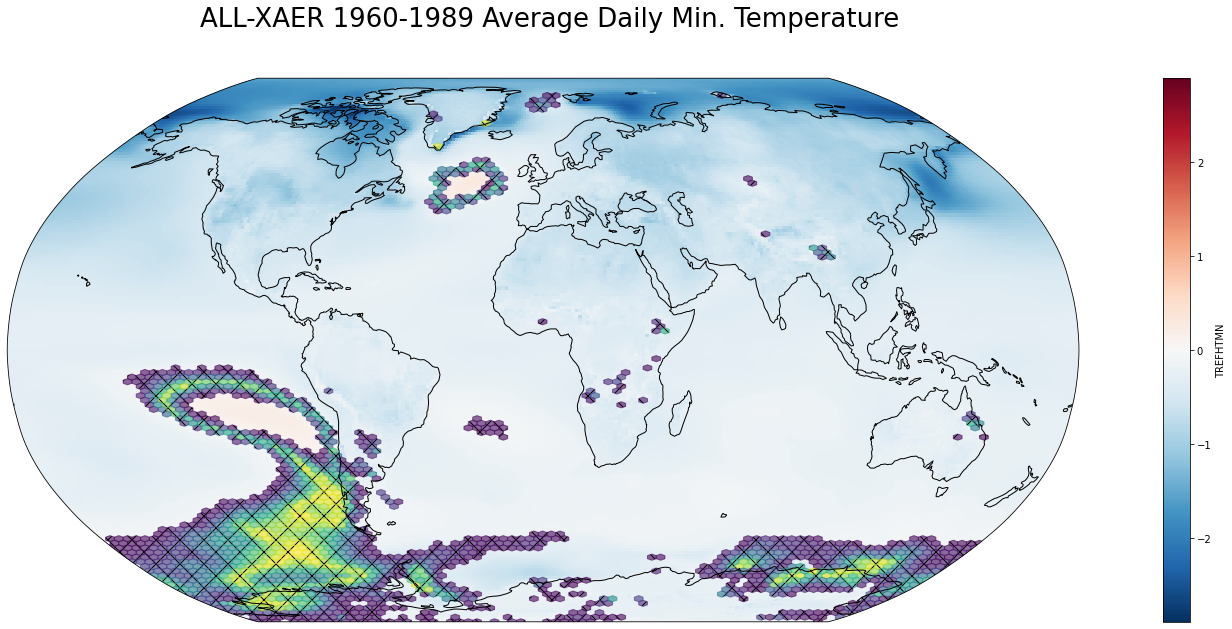

In [12]:
# Overlaying this on results means we just have to drop the hexbin alpha to zero as not to interfere with our primary plot
sig_mask = sig_results.where(sig_results >= 0.05)

X, Y = np.meshgrid(sig_results.lon, sig_results.lat) 
f, ax = plt.subplots(1, 1, figsize=(30, 10), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})
f.suptitle(f"ALL-XAER 1960-1989 Average Daily Min. Temperature", fontsize=26)

(all_ds-xaer_ds).mean(dim="year").mean(dim="member").plot(ax=ax, transform=ccrs.PlateCarree())
ax.hexbin(X.reshape(-1), Y.reshape(-1), sig_mask.data.reshape(-1), hatch='x', alpha=0.6, transform=ccrs.PlateCarree())
ax.coastlines()